# Submission for the AIcrowd Blitz Challenge FOODC

Author - Animesh Sinha

Based off template by - Pulkit Gera

To open the original template on Google Colab, click below!

[![Open Template In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/gist/aicrowd-bot/8a3e4b475f70e48ee7d5dfa168997073)


## Comments on the Solution

This notebook uses Inception Network used to detect food items in a very low quality dataset.

The results were decent, more needs to be done in cropping / bounding boxing the image. The training should also have been on a 100% of the dataset before the final submission, this was not done.

# Initial Setup

## Download the files
These include the train test images as well the csv indexing them

In [0]:
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/foodc/v0.1/train_images.zip
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/foodc/v0.1/test_images.zip
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/foodc/v0.1/train.csv
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/foodc/v0.1/test.csv

We create directories and unzip the images

In [0]:
!mkdir data
!mkdir data/test
!mkdir data/train
!unzip train_images -d data/train
!unzip test_images -d data/test

## Import necessary packages

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading Data

We are using Keras data generators to load images from the dataframe, resize them to (256, 256), scale the pixels down to [0, 1), and 

In [0]:
train = pd.read_csv('train.csv')
train.head()

ImageId               ClassName
0  f27632d7e5.jpg                   water
1  efa87919ed.jpg  pizza-margherita-baked
2  4f169e8c8d.jpg                broccoli
3  a6956654bf.jpg  salad-leaf-salad-green
4  d99ce8c3bf.jpg                     egg

In [0]:
TRAIN_IMAGES_DIR = "data/train/train_images/"

IMG_WIDTH, IMG_HEIGHT = 256, 256
BATCH_SIZE = 64

In [0]:
generator_preprocessor = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.1,
    rescale=1./255,
    zoom_range = 0.2,
    shear_range = 0.1,
    fill_mode = 'reflect',
    width_shift_range = 0.1,
    height_shift_range = 0.1
)
train_generator = generator_preprocessor.flow_from_dataframe(
    train,
    directory=TRAIN_IMAGES_DIR,
    x_col="ImageId",
    y_col="ClassName",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training',
    seed=None,
    validate_filenames=True,
)
validation_generator = generator_preprocessor.flow_from_dataframe(
    train,
    directory=TRAIN_IMAGES_DIR,
    x_col="ImageId",
    y_col="ClassName",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='validation',
    seed=None,
    validate_filenames=True,
)

Found 8391 validated image filenames belonging to 61 classes.
Found 932 validated image filenames belonging to 61 classes.


In [0]:
CLASS_NAMES = [value for value in train_generator.class_indices.keys()]
CLASS_COUNT = len(CLASS_NAMES)
print(CLASS_NAMES)

['almonds', 'apple', 'avocado', 'banana', 'beer', 'biscuits', 'boisson-au-glucose-50g', 'bread-french-white-flour', 'bread-sourdough', 'bread-white', 'bread-whole-wheat', 'bread-wholemeal', 'broccoli', 'butter', 'carrot', 'cheese', 'chicken', 'chips-french-fries', 'coffee-with-caffeine', 'corn', 'croissant', 'cucumber', 'dark-chocolate', 'egg', 'espresso-with-caffeine', 'french-beans', 'gruyere', 'ham-raw', 'hard-cheese', 'honey', 'jam', 'leaf-spinach', 'mandarine', 'mayonnaise', 'mixed-nuts', 'mixed-salad-chopped-without-sauce', 'mixed-vegetables', 'onion', 'parmesan', 'pasta-spaghetti', 'pickle', 'pizza-margherita-baked', 'potatoes-steamed', 'rice', 'salad-leaf-salad-green', 'salami', 'salmon', 'sauce-savoury', 'soft-cheese', 'strawberries', 'sweet-pepper', 'tea', 'tea-green', 'tomato', 'tomato-sauce', 'water', 'water-mineral', 'white-coffee-with-caffeine', 'wine-red', 'wine-white', 'zucchini']


We first convert the data labels into encodings using Label Encoders. This basically converts labels into number encodings. This is an important step as without it we cannot train our network

We load our train data and some necessary augementations like converting to PIL image, converting to tensors and normalizing them across channels. We can add more augementations such as `Random Flip`, `Random Rotation`, etc more on which can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html)

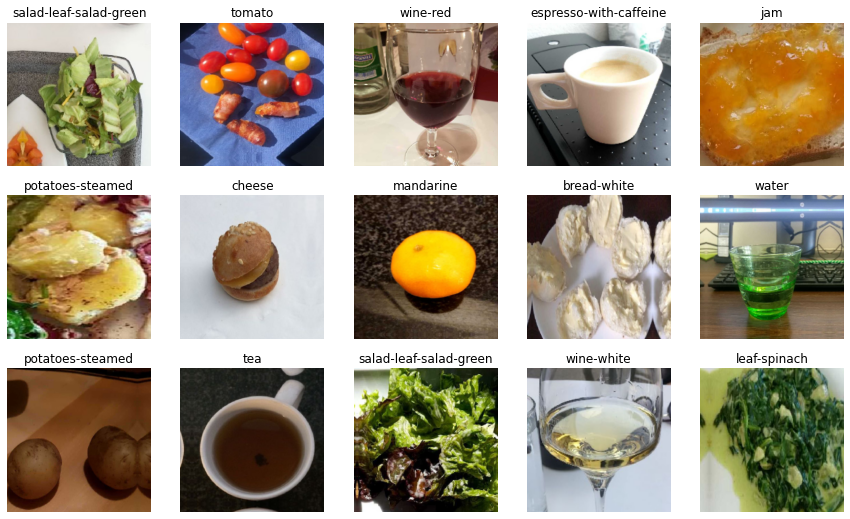

In [0]:
def show_batch(image_batch, label_batch, count = 25, classed = False):
    plt.figure(figsize=(15, ((count + 4) // 5) * 3))
    for n in range(count):
        ax = plt.subplot((count + 4) // 5, 5, n + 1)
        plt.imshow(image_batch[n])
        if not classed:
            plt.title(CLASS_NAMES[np.argmax(label_batch[n])])
        plt.axis('off')

image_batch, label_batch = next(iter(train_generator))
show_batch(image_batch, label_batch, 15)

# Multilayer Classification

## Semantic Information on Classes

Since classifying down to the specifics is very hard, we shall keep some broader classes to train the network in it's initial phases.

In [0]:
superclasses = {
    'bread-french-white-flour': ['bread-french-white-flour', 'bread-white', 'bread'], 
    'bread-sourdough': ['bread-sourdough', 'bread-white', 'bread'], 
    'bread-white': ['bread-white', 'bread-white', 'bread'], 
    'bread-whole-wheat': ['bread-whole-wheat', 'bread-brown', 'bread'], 
    'bread-wholemeal': ['bread-wholemeal', 'bread-brown', 'bread'], 
    'croissant': ['croissant', 'croissant', 'bread'], 

    'almonds': ['almonds', 'nuts', 'fruit'], 
    'mixed-nuts': ['mixed-nuts', 'nuts', 'fruit'], 
    'apple': ['apple', 'apple', 'fruit'], 
    'avocado': ['avocado', 'greens', 'fruit'], 
    'banana': ['banana', 'banana', 'fruit'], 

    'biscuits': ['biscuits', 'biscuits', 'snack'], 
    'chips-french-fries': ['chips-french-fries', 'fries', 'snack'], 
    'corn': ['corn', 'corn', 'snack'], 
    'dark-chocolate': ['dark-chocolate', 'chocolate', 'snack'], 
    'egg': ['egg', 'egg', 'snack'], 
    'potatoes-steamed': ['potatoes-steamed', 'potatoes', 'snack'], 

    'rice': ['rice', 'rice', 'meal'], 
    'pasta-spaghetti': ['pasta-spaghetti', 'pasta', 'meal'], 
    'pizza-margherita-baked': ['pizza-margherita-baked', 'pizza', 'meal'], 

    'mixed-vegetables': ['mixed-vegetables', 'greens', 'food'], 
    'pickle': ['pickle', 'greens', 'food'], 
    'broccoli': ['broccoli', 'greens', 'food'], 
    'cucumber': ['cucumber', 'greens', 'food'], 
    'french-beans': ['french-beans', 'greens', 'food'], 
    'zucchini': ['zucchini', 'greens', 'food'],
    'leaf-spinach': ['leaf-spinach', 'salad', 'food'], 
    'salad-leaf-salad-green': ['salad-leaf-salad-green', 'salad', 'food'], 
    'mixed-salad-chopped-without-sauce': ['mixed-salad-chopped-without-sauce', 'salad', 'food'], 
    'sweet-pepper': ['sweet-pepper', 'reds', 'food'], 
    'strawberries': ['strawberries', 'reds', 'food'], 
    'tomato': ['tomato', 'reds', 'food'], 
    'carrot': ['carrot', 'reds', 'food'], 
    'tomato-sauce': ['tomato-sauce', 'sauce', 'food'], 
    'sauce-savoury': ['sauce-savoury', 'sauce', 'food'], 
    'onion': ['onion', 'onion', 'food'], 

    'chicken': ['chicken', 'white-meat', 'meat'], 
    'salami': ['salami', 'red-meat', 'meat'], 
    'salmon': ['salmon', 'white-meat', 'meat'], 
    'ham-raw': ['ham-raw', 'red-meat', 'meat'], 

    'honey': ['honey', 'honey', 'food'], 
    'jam': ['jam', 'jam', 'food'], 

    'butter': ['butter', 'butter', 'food'], 
    'cheese': ['cheese', 'cheese', 'food'], 
    'gruyere': ['gruyere', 'cheese', 'food'], 
    'soft-cheese': ['soft-cheese', 'cheese', 'food'], 
    'hard-cheese': ['hard-cheese', 'cheese', 'food'], 
    'parmesan': ['parmesan', 'cheese', 'food'], 
    'mandarine': ['mandarine', 'butter', 'food'], 
    'mayonnaise': ['mayonnaise', 'butter', 'food'], 

    'boisson-au-glucose-50g': ['boisson-au-glucose-50g', 'water', 'drinks'], 
    'water': ['water', 'water', 'food'], 
    'water-mineral': ['water-mineral', 'food', 'food'], 
    'tea': ['tea', 'tea', 'drinks'],
    'tea-green': ['tea-green', 'tea', 'drinks'],
    'coffee-with-caffeine': ['coffee-with-caffeine', 'food', 'food'], 
    'white-coffee-with-caffeine': ['white-coffee-with-caffeine', 'coffee', 'food'], 
    'espresso-with-caffeine': ['espresso-with-caffeine', 'coffee', 'food'], 
    'beer': ['beer', 'alcohol', 'food'], 
    'wine-red': ['wine-red', 'alcohol', 'food'], 
    'wine-white': ['wine-white', 'alcohol', 'food'], 
}

In [0]:
train['L1'] = train.ClassName.map(lambda x: superclasses[x][2])
train['L2'] = train.ClassName.map(lambda x: superclasses[x][1])
train['L3'] = train.ClassName.map(lambda x: superclasses[x][0])
train.head()

ImageId               ClassName  ...      L2                      L3
0  f27632d7e5.jpg                   water  ...   water                   water
1  efa87919ed.jpg  pizza-margherita-baked  ...   pizza  pizza-margherita-baked
2  4f169e8c8d.jpg                broccoli  ...  greens                broccoli
3  a6956654bf.jpg  salad-leaf-salad-green  ...   salad  salad-leaf-salad-green
4  d99ce8c3bf.jpg                     egg  ...     egg                     egg

[5 rows x 5 columns]

In [0]:
train_generator_l1 = generator_preprocessor.flow_from_dataframe(
    train, directory=TRAIN_IMAGES_DIR, x_col="ImageId", y_col="L1", 
    target_size=(256, 256), color_mode="rgb", class_mode="categorical",
    batch_size=BATCH_SIZE, shuffle=True, subset='training',
)
train_generator_l2 = generator_preprocessor.flow_from_dataframe(
    train, directory=TRAIN_IMAGES_DIR, x_col="ImageId", y_col="L2", 
    target_size=(256, 256), color_mode="rgb", class_mode="categorical",
    batch_size=BATCH_SIZE, shuffle=True, subset='training',
)
train_generator_l3 = generator_preprocessor.flow_from_dataframe(
    train, directory=TRAIN_IMAGES_DIR, x_col="ImageId", y_col="L3", 
    target_size=(256, 256), color_mode="rgb", class_mode="categorical",
    batch_size=BATCH_SIZE, shuffle=True, subset='training',
)
validation_generator_l1 = generator_preprocessor.flow_from_dataframe(
    train, directory=TRAIN_IMAGES_DIR, x_col="ImageId", y_col="L1", 
    target_size=(256, 256), color_mode="rgb", class_mode="categorical",
    batch_size=BATCH_SIZE, shuffle=True, subset='validation',
)
validation_generator_l2 = generator_preprocessor.flow_from_dataframe(
    train, directory=TRAIN_IMAGES_DIR, x_col="ImageId", y_col="L2", 
    target_size=(256, 256), color_mode="rgb", class_mode="categorical",
    batch_size=BATCH_SIZE, shuffle=True, subset='validation',
)
validation_generator_l3 = generator_preprocessor.flow_from_dataframe(
    train, directory=TRAIN_IMAGES_DIR, x_col="ImageId", y_col="L3", 
    target_size=(256, 256), color_mode="rgb", class_mode="categorical",
    batch_size=BATCH_SIZE, shuffle=True, subset='validation',
)

Found 8391 validated image filenames belonging to 7 classes.
Found 8391 validated image filenames belonging to 31 classes.
Found 8391 validated image filenames belonging to 61 classes.
Found 932 validated image filenames belonging to 7 classes.
Found 932 validated image filenames belonging to 31 classes.
Found 932 validated image filenames belonging to 61 classes.


## Train a Small Model on L1

Training the MobileNet model on the most general classes possible to feed as a data vector to the next layer.

In [0]:
# mobile = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False)
# l1 = mobile.output
# l1 = tf.keras.layers.GlobalAveragePooling2D()(l1)
# l1 = tf.keras.layers.Dense(128)(l1)
# predictions = tf.keras.layers.Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.02), activation='softmax')(l1)
# l1.trainable = True

# model_l1 = tf.keras.models.Model(inputs=mobile.input, outputs=predictions)
# model_l1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [0]:
# model.fit(
#     train_generator,
#     validation_data = validation_generator, 
#     steps_per_epoch = train_generator.n // BATCH_SIZE + 1, 
#     epochs = 20,
#     validation_steps = validation_generator.n // BATCH_SIZE + 1,
#     callbacks = [
#         tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1),
#         tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience=2, factor=0.1, verbose = 1)
#     ]
# )

# Exploratory Data Analysis

## Distribution of Images

Let us do some exploratory data analysis. The idea is to see the class distribution, how the images are and much more. 

Percentage of each class


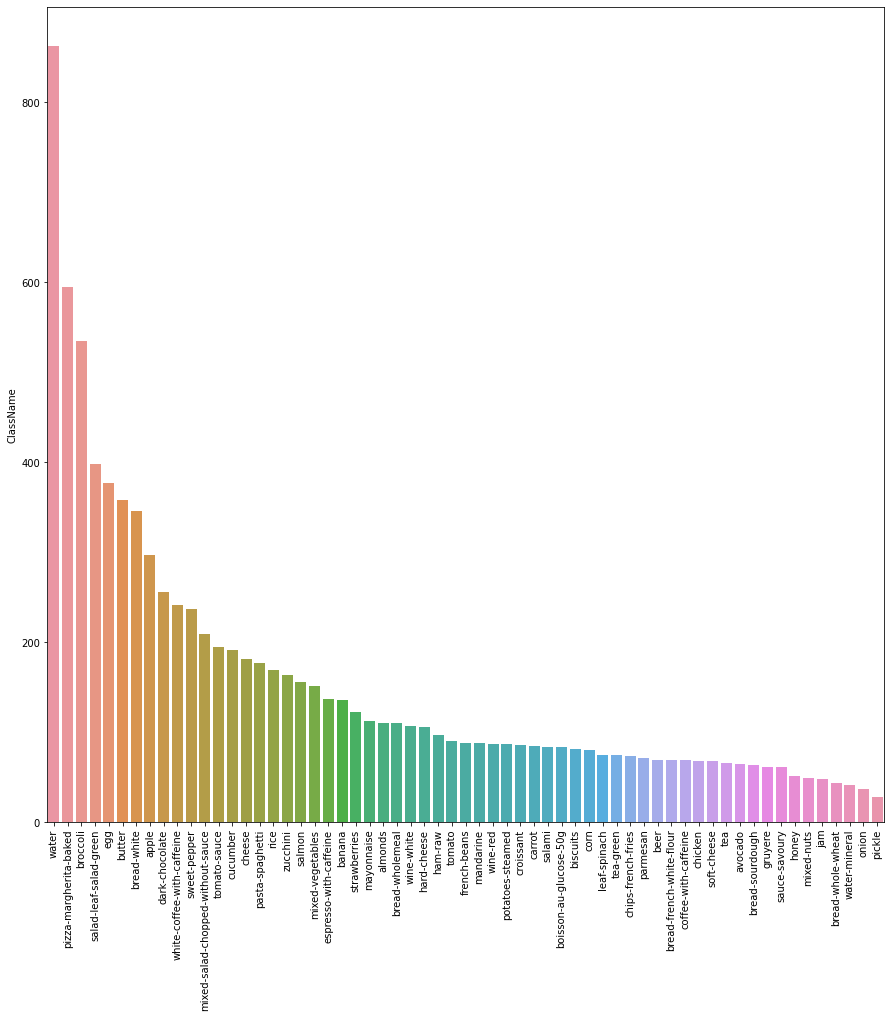

In [0]:
train = pd.read_csv('train.csv')
num = train['ClassName'].value_counts()
classes = train['ClassName'].unique()
print("Percentage of each class")

plt.figure(figsize=(15, 15))
chart = sns.barplot(x=classes, y=num)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

We observe that water is the most popular class although the distribution is not that skewed. Let us plot the images of white flour french bread and french fries and have a look at the kind of images we have

In [0]:
def visualize_class(class_name, count = 10):
    visualization_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        validation_split=0.1,
        rescale=1./255,
    ).flow_from_dataframe(
        train[train['ClassName'] == class_name],
        directory=TRAIN_IMAGES_DIR,
        x_col="ImageId",
        y_col="ClassName",
        target_size=(256, 256),
        color_mode="rgb",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        validate_filenames=True,
    )
    image_batch, label_batch = next(iter(visualization_generator))
    show_batch(image_batch, label_batch, count, classed=True)

Found 863 validated image filenames belonging to 1 classes.


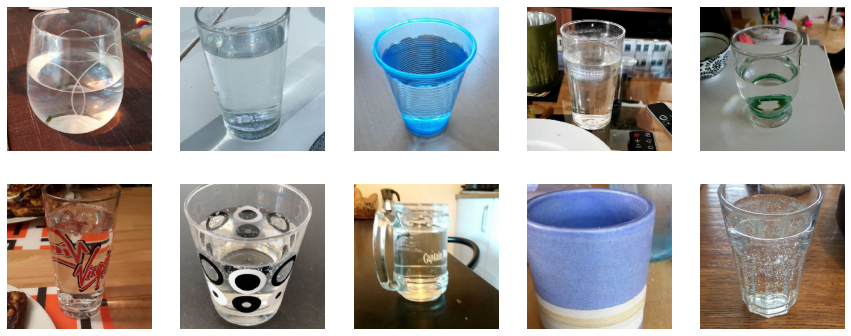

In [0]:
visualize_class('water')

Found 61 validated image filenames belonging to 1 classes.


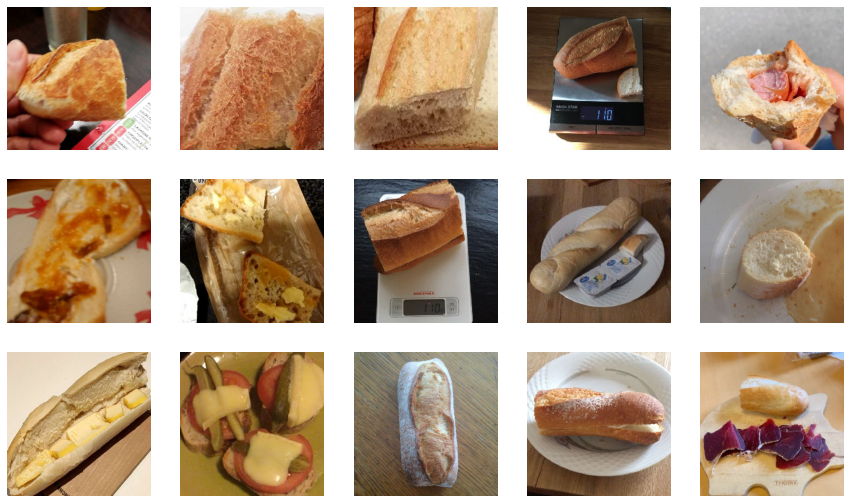

In [0]:
visualize_class('bread-french-white-flour', 15)

Found 86 validated image filenames belonging to 1 classes.


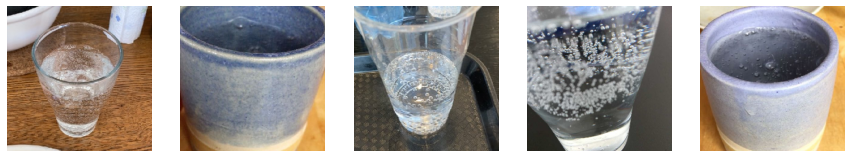

In [0]:
visualize_class('water-mineral', 5)

# Define the Model
Now we come to the juicy part. We define our model here. We need to create a class with `__init__` and `forward` functions which define the layers and forward pass respectively. We can also load pretrained models and freeze their layers and add more layers on top of it, to train them. More on pretrained models with pytorch [here](https://pytorch.org/docs/stable/torchvision/models.html) and making models [here](https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/).

## Small Self-made model

Here we define a convolutional neural network.

In [0]:
# def make_model():
#     input_image = tf.keras.layers.Input((256, 256, 3))

#     net = tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), padding='same', activation='relu')(input_image)
#     net = tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), padding='same', activation='relu')(net)
#     net = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(net)

#     net = tf.keras.layers.Conv2D(filters=24, kernel_size=(3, 3), padding='same', activation='relu')(net)
#     net = tf.keras.layers.Conv2D(filters=36, kernel_size=(3, 3), padding='same', activation='relu')(net)
#     net = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(net)

#     net = tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), padding='same', activation='relu')(net)
#     net = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(net)
#     net = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(net)
    
#     net = tf.keras.layers.Flatten()(net)
#     net = tf.keras.layers.Dense(150)(net)
#     net = tf.keras.layers.Dense(81)(net)
#     net = tf.keras.layers.Dense(61)(net)

#     model = tf.keras.models.Model(inputs=[input_image], outputs=[net])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#     return model

# model = make_model()
# model.summary()

# tf.keras.utils.plot_model(model, to_file='model.png')

Here we define our model object along with our optimizer and error function. Typically for multi class classification we use `Cross Entropy Loss`. More about different types of losses are [here](https://pytorch.org/docs/stable/nn.html#loss-functions).   
We use the popular Adam optimizer with its default parameters. There are other optimizers like `SGD`, `RMSPROP`, `Adamax`,etc. You can have a detailed look at optimizers [here](https://pytorch.org/docs/stable/optim.html)

## Inception Net

87916544/87910968 [==============================] - 2s 0us/step


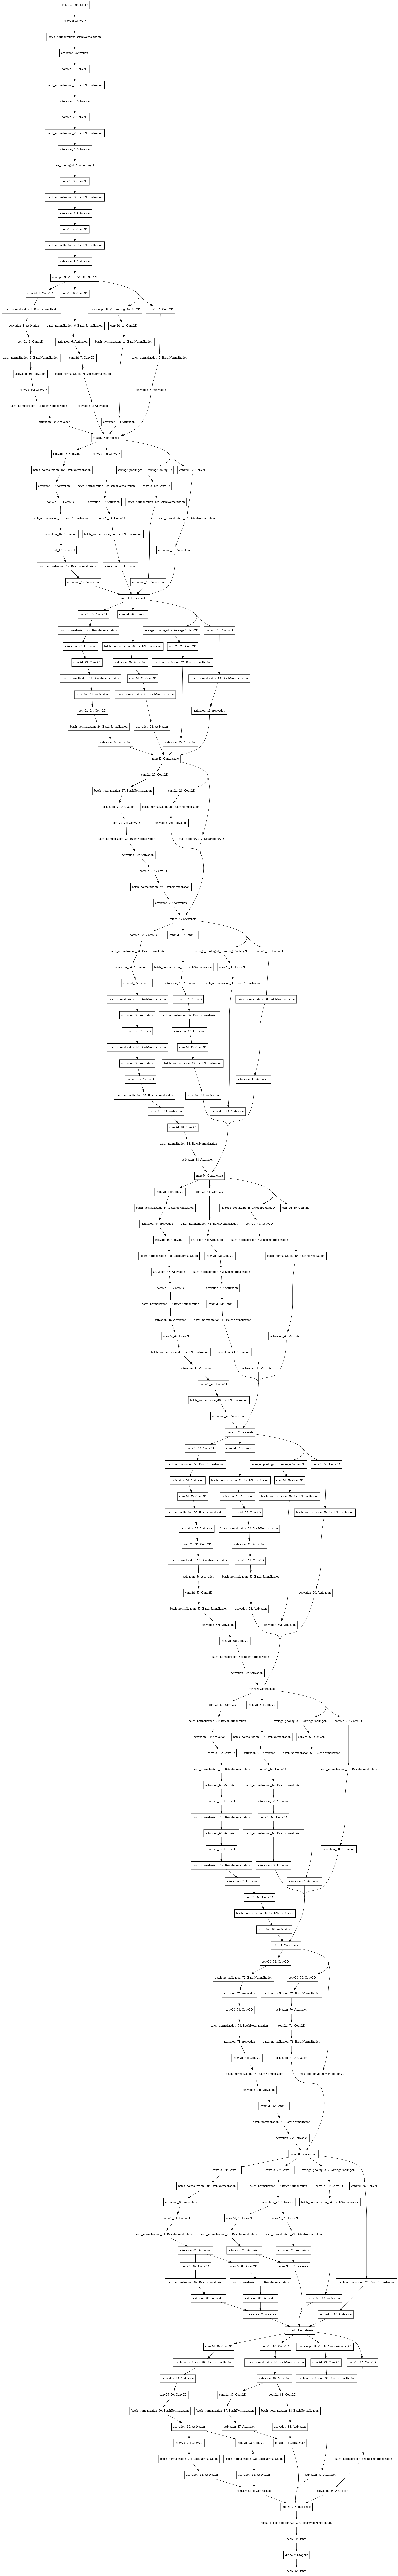

In [0]:
inception = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Dropout(0.2)(x)
predictions = tf.keras.layers.Dense(61, kernel_regularizer=tf.keras.regularizers.l2(0.02), activation='softmax')(x)

inception.output.trainable = True

model = tf.keras.models.Model(inputs=inception.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer= 'Adam')
tf.keras.utils.plot_model(model, to_file='model.png')

## Train and Validate 
Alright enough talk and time to train. We define the number of epochs and train the model. An epoch is a forward pass and backward pass of all the data points. An epoch consists of iterations which depend on batch size. So basically we take a batch, get its output, do a backward pass and let the optimizer take a step. This is the workflow for any pytorch code.  


Now after an epoch ends, we check with validation and do the same steps except backward pass on loss and optimizer step. If we get a reduction in validation loss, we save the model. This is sort of an early stopping.

In [0]:
model.fit(
    train_generator,
    validation_data = validation_generator, 
    steps_per_epoch = train_generator.n // BATCH_SIZE + 1, 
    epochs = 20,
    validation_steps = validation_generator.n // BATCH_SIZE + 1,
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience=2, factor=0.1, verbose = 1)
    ]
)

Epoch 1/20
132/132 [==============================] - ETA: 0s - loss: 3.6517 - accuracy: 0.3491
Epoch 00001: saving model to best_model.h5
132/132 [==============================] - 207s 2s/step - loss: 3.6517 - accuracy: 0.3491 - val_loss: 16.8542 - val_accuracy: 0.0451 - lr: 0.0010
Epoch 2/20
132/132 [==============================] - ETA: 0s - loss: 2.5243 - accuracy: 0.4504
Epoch 00002: saving model to best_model.h5
132/132 [==============================] - 202s 2s/step - loss: 2.5243 - accuracy: 0.4504 - val_loss: 5.4630 - val_accuracy: 0.1352 - lr: 0.0010
Epoch 3/20
132/132 [==============================] - ETA: 0s - loss: 2.1147 - accuracy: 0.4892
Epoch 00003: saving model to best_model.h5
132/132 [==============================] - 203s 2s/step - loss: 2.1147 - accuracy: 0.4892 - val_loss: 2.5179 - val_accuracy: 0.3498 - lr: 0.0010
Epoch 4/20
132/132 [==============================] - ETA: 0s - loss: 1.8956 - accuracy: 0.5216
Epoch 00004: saving model to best_model.h5
132/132 

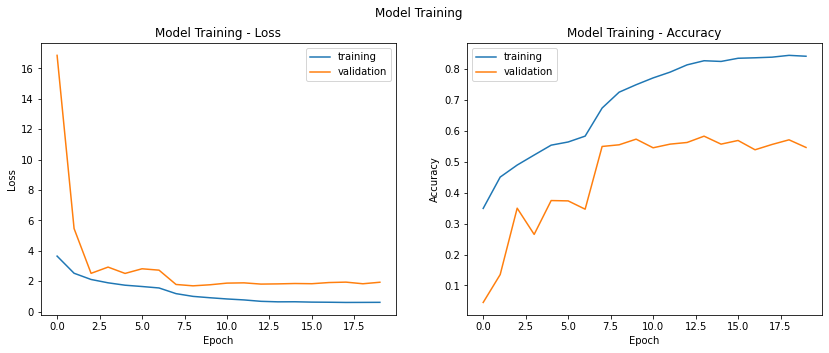

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Model Training')

ax1.plot(model.history.history['loss'], label='training')
ax1.plot(model.history.history['val_loss'], label='validation')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Model Training - Loss')

ax2.plot(model.history.history['accuracy'], label='training')
ax2.plot(model.history.history['val_accuracy'], label='validation')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Model Training - Accuracy')

plt.show()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
model.save('/content/gdrive/My Drive/model.h5')

# Predictions and Output

## Predict on Validation
Now we predict our trained model on the validation set and evaluate our model

In [0]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/model.h5') # 'best_model.h5'

In [0]:
validation_generator = generator_preprocessor.flow_from_dataframe(
    train, directory=TRAIN_IMAGES_DIR, x_col="ImageId", y_col="ClassName", 
    target_size=(256, 256), color_mode="rgb", class_mode="categorical",
    batch_size=BATCH_SIZE, shuffle=False,
)

y_pred = np.argmax(model.predict(validation_generator, steps = validation_generator.n // BATCH_SIZE + 1, verbose=True), axis=1)

Found 9323 validated image filenames belonging to 61 classes.
146/146 [==============================] - 1399s 10s/step


## Evaluate the Performance
We use the same metrics as that will be used for the test set.  
[F1 score](https://en.wikipedia.org/wiki/F1_score) and [Log Loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) are the metrics for this challenge

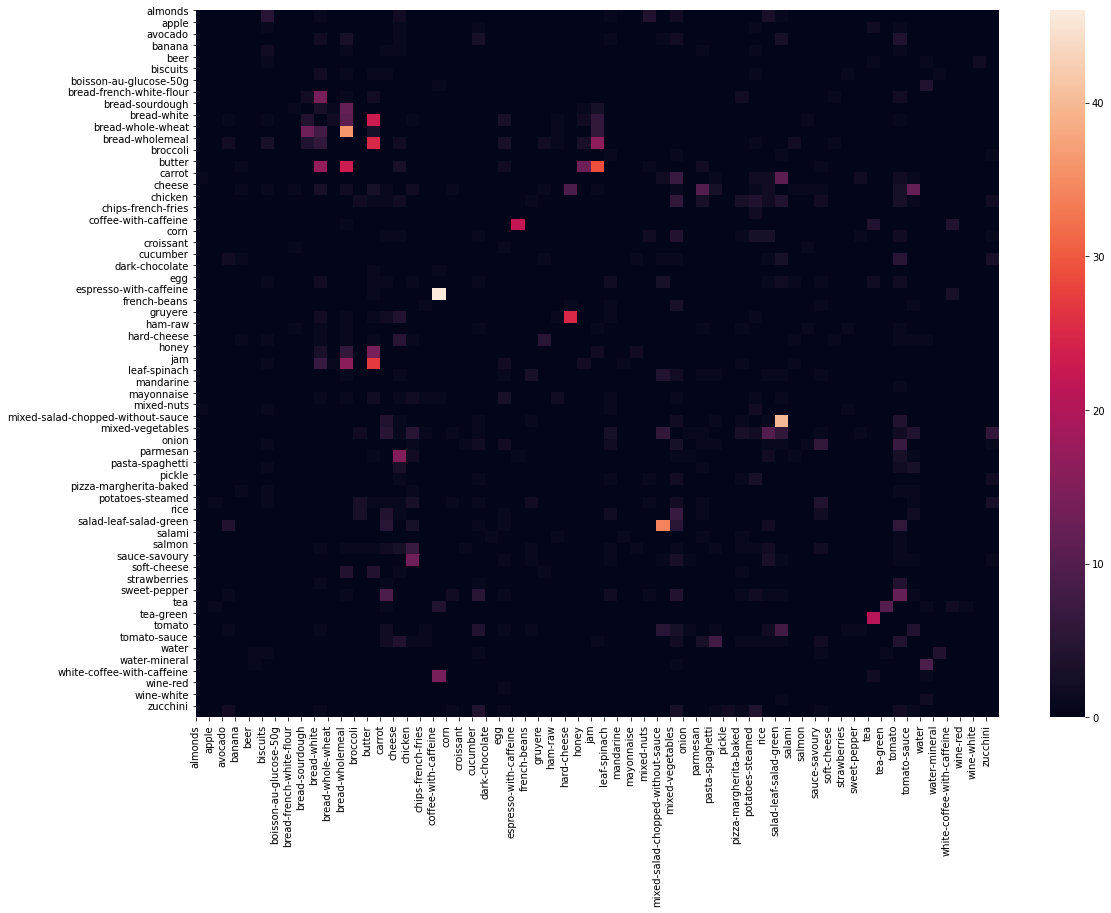

In [0]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

plt.figure(figsize=(18, 13))
confusion = confusion_matrix(validation_generator.classes, y_pred)
for i in range(len(confusion)):
    confusion[i][i] = 0
sns.heatmap(confusion)
plt.yticks(np.arange(CLASS_COUNT), CLASS_NAMES)
plt.xticks(np.arange(CLASS_COUNT), CLASS_NAMES, rotation='vertical')
plt.show()

In [0]:
for i in range(CLASS_COUNT):
    for j in range(CLASS_COUNT):
        if confusion[i][j] > 20 and i != j:
            print(CLASS_NAMES[i], 'gets recognized as', CLASS_NAMES[j], 'with frequency', confusion[i][j])

bread-white gets recognized as butter with frequency 23
bread-whole-wheat gets recognized as bread-wholemeal with frequency 36
bread-wholemeal gets recognized as butter with frequency 25
butter gets recognized as bread-wholemeal with frequency 23
butter gets recognized as jam with frequency 29
coffee-with-caffeine gets recognized as espresso-with-caffeine with frequency 22
espresso-with-caffeine gets recognized as coffee-with-caffeine with frequency 46
gruyere gets recognized as hard-cheese with frequency 25
jam gets recognized as butter with frequency 27
mixed-salad-chopped-without-sauce gets recognized as salad-leaf-salad-green with frequency 40
salad-leaf-salad-green gets recognized as mixed-salad-chopped-without-sauce with frequency 34
tea-green gets recognized as tea with frequency 21


In [0]:
from sklearn.metrics import f1_score, precision_score, log_loss
print("F1 score :", f1_score(validation_generator.classes, y_pred, average='micro'))

F1 score : 0.8385712753405556


## Predict on test set
Time for the moment of truth! Predict on test set and time to make the submission.

In [0]:
test = pd.read_csv('test.csv')
TEST_IMAGES_DIR = 'data/test/test_images'
test.head()

ImageId
0  90e63a2fde.jpg
1  a554d1ca8d.jpg
2  48317e8ee8.jpg
3  79528df667.jpg
4  6d2f2f63f5.jpg

In [0]:
test_generator = generator_preprocessor.flow_from_dataframe(
    test,
    directory=TEST_IMAGES_DIR,
    x_col="ImageId",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validate_filenames=True,
)

Found 484 validated image filenames.


In [0]:
y_test = np.argmax(
    model.predict(test_generator, steps = test_generator.n // BATCH_SIZE + 1), 
    axis=1
)

## Save it in correct format

In [0]:
# Create Submission file
df = pd.DataFrame([CLASS_NAMES[y] for y in y_test],columns=['ClassName'])
df.to_csv('submission.csv',index=False)

In [0]:
df.head()

ClassName
0            water
1    water-mineral
2    water-mineral
3      hard-cheese
4  bread-wholemeal

To download the generated in collab csv run the below command

In [0]:
from google.colab import files
files.download('submission.csv')

Go to [platform](https://www.aicrowd.com/challenges/aicrowd-blitz-may-2020/problems/foodc). Participate in the challenge and submit the submission.csv.